## Align to Neighbour (Phase and Delay)

This notebook demonstrates an extension of the WDvS13 method controlling stochastic delay and phase noise in $H(\nu,t)e^{i(\phi_t+\epsilon_t \nu)}$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, $\phi_t$ and $\epsilon_t$ are the unknown degenerate phase and delay at time $t$.

Each $H(\nu,t)$ is aligned to its neighbour by minimizing the difference between them as a function of delay $\phi$ and phase gradient $\epsilon$, where the difference is

$$ \chi^2 = \sum_\nu | H(\nu,t) - H(\nu,t+\Delta t) e^{i(\phi+\epsilon \nu)} |^2 $$

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import psrchive
from pycyc import align_to_neighbour

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Astrophysical scattering screen

The file `giant_pulse_filters.fits` contains $H*(\nu,t)$, the complex conjugate of the frequency reponses derived from the baseband voltage data for the giant pulses with the greatest S/N in each 20-second interval containing $t$.  Assuming that the intrinsic giant pulse is a delta function, each giant pulse can be treated as an estimate of the impulse response function, the Fourier transform of which is the frequency response.  The complex conjugate is taken because the responses are passed to dspsr to implement matched filtering.

In [2]:
filename = "giant_pulse_filters.fits"
ar = psrchive.Archive_load(filename)
ext = ar.get_dynamic_response()
data = ext.get_data()
nchan = ext.get_nchan()
ntime = ext.get_ntime()

# take conjugate because git_pulse_filters.fits contains matched filters
h_time_freq = np.conj(np.reshape(data, (ntime, nchan)))

start_time = ext.get_minimum_epoch ()
end_time = ext.get_maximum_epoch ()
dT = (end_time-start_time).in_seconds() / ntime

print(f"{ntime=} start_time={start_time.printdays(13)} end_time={end_time.printdays(13)} delta-T={dT}")

bw = ext.get_bandwidth()
cfreq = ext.get_centre_frequency()

print(f"{nchan=} centre frequency={cfreq} bandwidth={bw}")

h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

ntime=177 start_time=53873.3225115741006 end_time=53873.3634837963036 delta-T=19.999999990607847
nchan=1120 centre frequency=428.0 bandwidth=4.0


Average Power: 1.0000000000000002


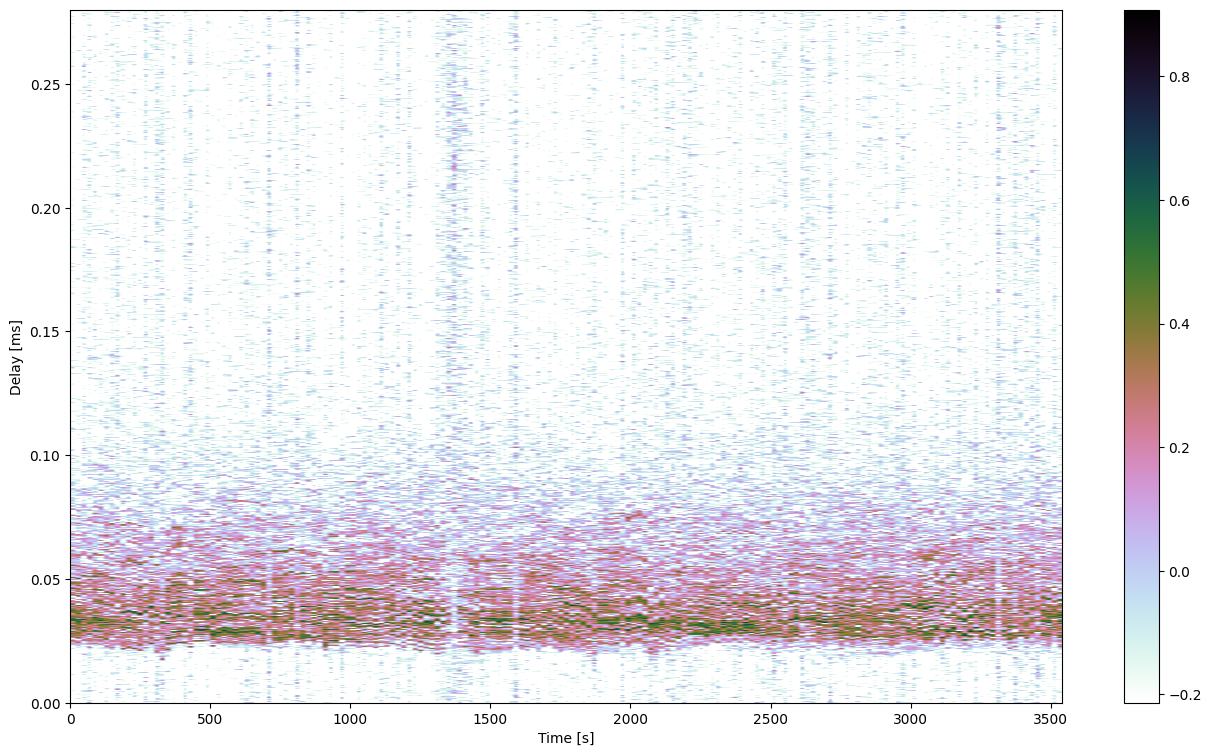

In [3]:
def plot_time_vs_delay (h_time_delay, dT, cfreq, bw):

    ntime, ntap = h_time_delay.shape
    
    power = np.sum(np.abs(h_time_delay)**2) / (ntime * ntap)
    print(f"Average Power: {power}")
 
    plotthis = np.log10(np.abs(h_time_delay) + 1e-2)
    plotmed = np.median(plotthis)

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 1e-3
    extent=[0, dT*ntime, 0, max_delay_ms]
    
    fig, ax = plt.subplots(figsize=(16, 9))
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Delay [ms]")
    fig.colorbar(img)

plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Unaligned Wavefield

A Fourier transform along the delay axis yields $H(\nu,t)$, which is then passed to the plot function, which computes and plots the 2D FFT, $h(\tau,\omega)$.  This is expected to look like white Doppler noise because of the large time shifts $\epsilon_t$ that are clearly visible in the above plot.

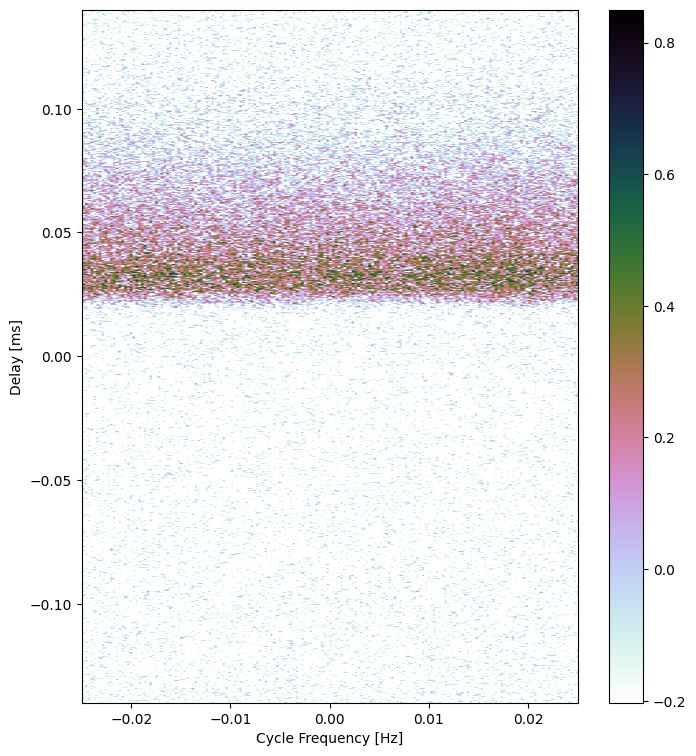

In [4]:
def plot_Doppler_vs_delay (h_time_freq, dT, cfreq, bw):

    h_time_delay = freq2time(h_time_freq, axis=1)
    h_doppler_delay = time2freq(h_time_delay, axis=0)

    ntime, ntap = h_time_delay.shape

    delta_delay_mus = np.abs(1.0 / bw)
    max_delay_ms = delta_delay_mus * ntap * 0.5e-3
    max_Doppler_Hz = .5 / dT
    
    extent=[-max_Doppler_Hz, max_Doppler_Hz, -max_delay_ms, max_delay_ms]
    
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    plotmed = np.median(plotthis)
    fig, ax = plt.subplots(figsize=(8, 9))

    ax.set_xlabel("Cycle Frequency [Hz]")
    ax.set_ylabel("Delay [ms]")
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=plotmed, extent=extent)

    fig.colorbar(img)
    
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)

In [5]:
align_to_neighbour(h_time_freq)
h_time_delay = ifft(h_time_freq,axis=1,norm="ortho")

## Aligned Impulse Responses

It's nice to see temporally persistent features in the impulse responses.

Average Power: 1.0000000000000002


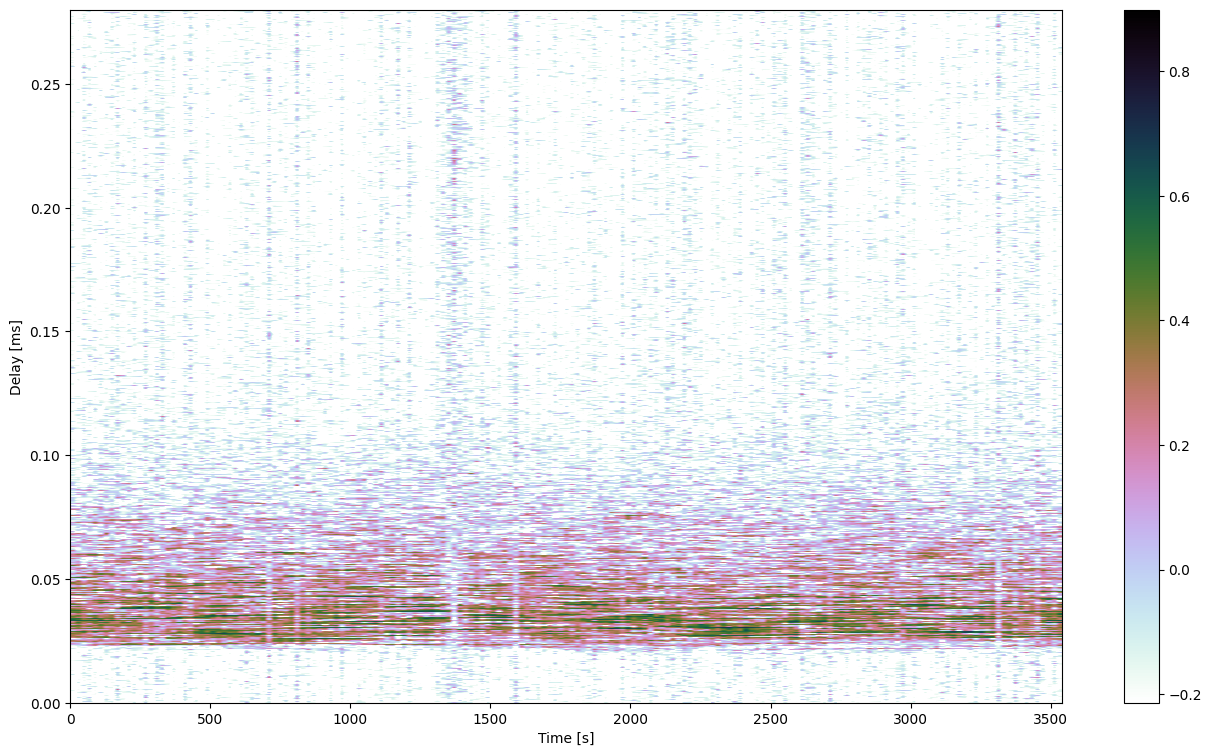

In [6]:
plot_time_vs_delay(h_time_delay, dT, cfreq, bw)

## Aligned Response Wavefield

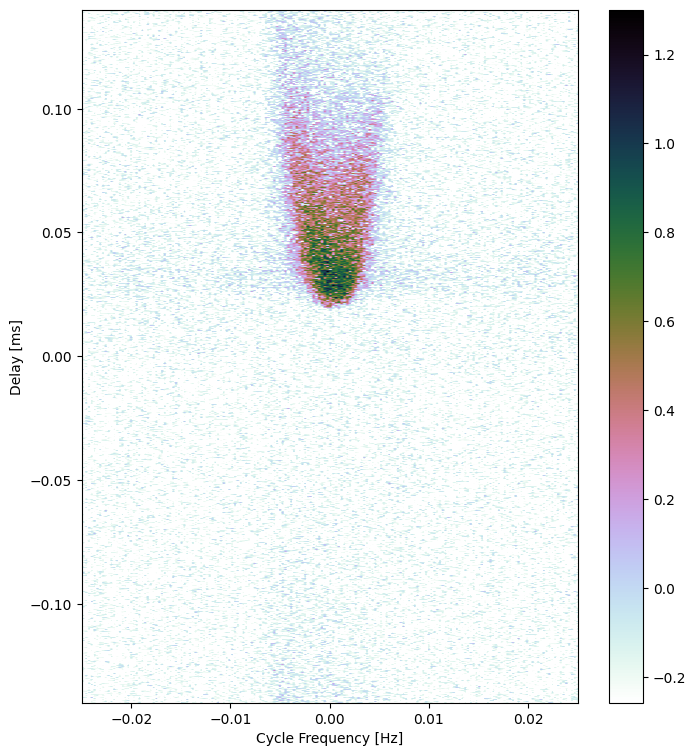

In [7]:
plot_Doppler_vs_delay(h_time_freq, dT, cfreq, bw)